In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install tensorflow==2.0.0
    !pip install tensorflow_probability==0.8.0
    !pip install h5py==2.10.0

In [3]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  True


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import urllib.request
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.0.0


In [5]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


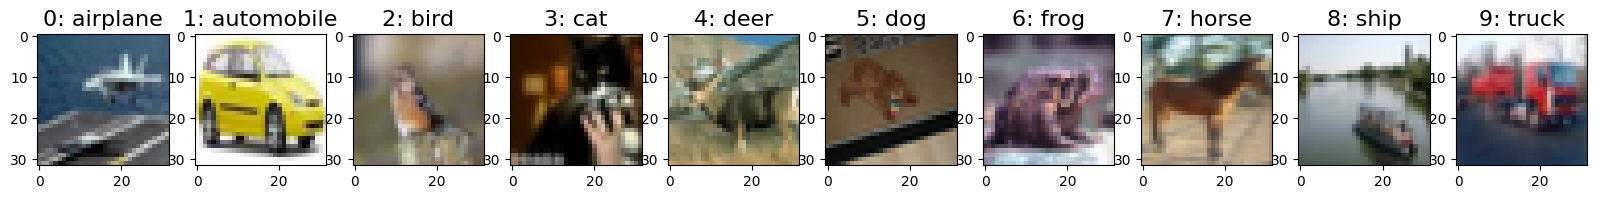

In [7]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])
#sample image of each label
np.random.seed(123456)
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(np.str(y_train[rmd][0][0])+ ": " +labels[i],fontsize=16)
#plt.savefig("Figure_8_cifar.pdf")
#from google.colab import files
#files.download('Figure_8_cifar.pdf') 

In [8]:
#Remove Horses
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
print("x_train shape: ", x_train_no_horse.shape)
print("\ny_train shape (normal): ", y_train_no_horse.shape)

print("Example Label (normal): ", y_train_no_horse[0])
#One-Hot-Encoding
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder(handle_unknown='ignore')
#enc.fit(y_train_no_horse.reshape(-1,1))
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])
print("\ny_train shape (one-hot-encoded): ", y_train_no_horse.shape)
print("Example Label (one-hot-encoded): ", y_train_no_horse[0])

x_train shape:  (45000, 32, 32, 3)

y_train shape (normal):  (45000,)
Example Label (normal):  6

y_train shape (one-hot-encoded):  (45000, 9)
Example Label (one-hot-encoded):  [0 0 0 0 0 0 1 0 0]


In [9]:
#Split intro Training and Validation Data
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)
print("\nTraining Data Size:")
print(x_train.shape)
print(y_train.shape)
print("\nValidation Data Size:")
print(x_val.shape)
print(y_val.shape)
print("\nTest Data Size:")
print(x_test.shape)
print(y_test.shape)

#Normalization: Data between -1 and 1.
print("\nMin/Max Value of x_test Data:")
print(x_test.min(), x_test.max())
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2
print("\nMin/Max Value of x_test Data (normalized):")

print(x_test.min(), x_test.max())


Training Data Size:
(27000, 32, 32, 3)
(27000, 9)

Validation Data Size:
(18000, 32, 32, 3)
(18000, 9)

Test Data Size:
(10000, 32, 32, 3)
(10000, 1)

Min/Max Value of x_test Data:
0 255

Min/Max Value of x_test Data (normalized):
-1.0 1.0


In [10]:
#Define Deterministic Model
#CNN Model (tf only)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(tf.keras.layers.Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(tf.keras.layers.Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dropout((0.5)))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dropout((0.5)))
model.add(tf.keras.layers.Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________

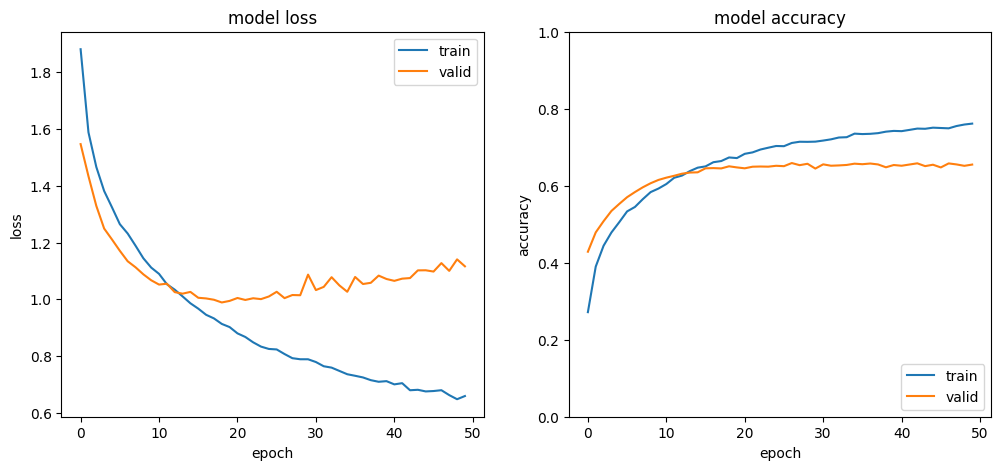

In [65]:
#Train Deterministic Model
#CNN (tf only)

#history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=50,verbose=1)

#Training takes too long, load history instead:
urllib.request.urlretrieve("https://raw.githubusercontent.com/danielwalltu/ml_bnn/main/history.txt", "history.txt")
history=np.genfromtxt("history.txt",delimiter=",")
urllib.request.urlretrieve("https://raw.githubusercontent.com/danielwalltu/ml_bnn/main/model_weights.hdf5", "model_weights.hdf5")
model.load_weights("model_weights.hdf5")


plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,1)
plt.plot(history[:,2])
plt.plot(history[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [12]:
#Define Probabilistic Model
#CNN Model (tfp)

kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] *1.0)

model_bnn = tf.keras.Sequential()
model_bnn.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
model_bnn.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_bnn.add(tf.keras.layers.MaxPooling2D((2,2)))
model_bnn.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_bnn.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_bnn.add(tf.keras.layers.MaxPooling2D((2,2)))
model_bnn.add(tf.keras.layers.Flatten())
model_bnn.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_bnn.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_bnn.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model_bnn.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_bnn.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_______________________________________________

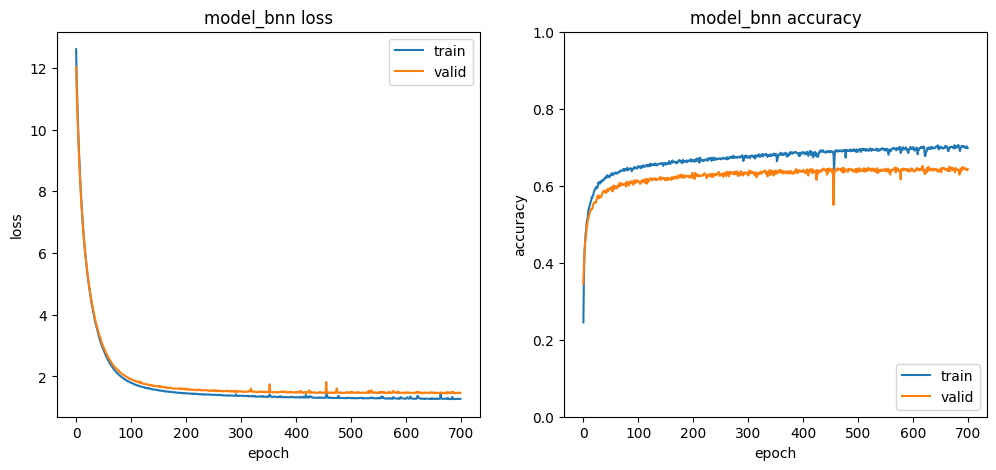

In [66]:
#Train Probabilistic Model
#CNN Model (tfp)

#Training takes even longer, load history instead:
#history_bnn = model_bnn.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=700,verbose=1)

urllib.request.urlretrieve("https://raw.githubusercontent.com/danielwalltu/ml_bnn/main/history_bnn.txt", "history_bnn.txt")
history_bnn=np.genfromtxt("history_bnn.txt",delimiter=",", dtype='float')
urllib.request.urlretrieve("https://raw.githubusercontent.com/danielwalltu/ml_bnn/main/model_bnn_weights.hdf5", "model_bnn_weights.hdf5")
model_bnn.load_weights("model_bnn_weights.hdf5")

fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].plot(history_bnn[:,0])
axs[0].plot(history_bnn[:,2])
axs[0].set_title('model_bnn loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'valid'], loc='upper right')
axs[1].plot(history_bnn[:,1])
axs[1].plot(history_bnn[:,3])
axs[1].set_ylim(0, 1)
axs[1].set_title('model_bnn accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'valid'], loc='lower right')

In [ ]:
plt.plot(range(700), bnn_)

Output vector and label of the chosen example:
[0 0 1 0 0 0 0 0 0]
bird


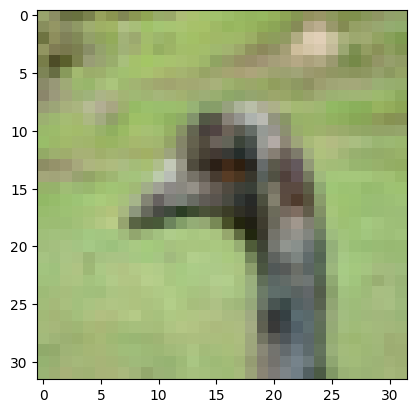

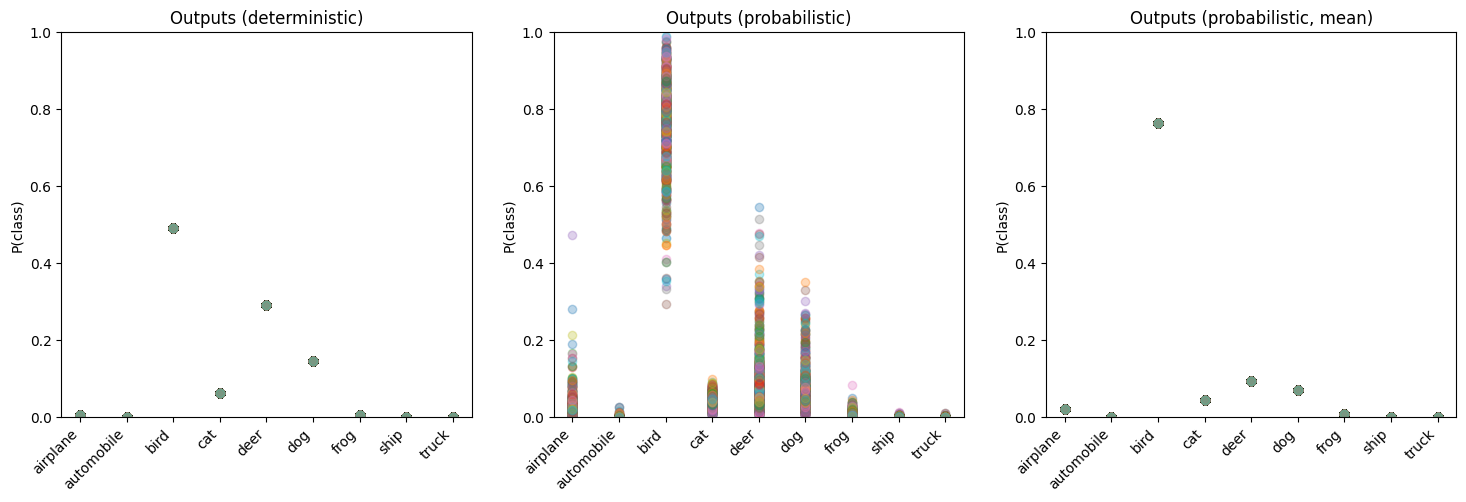

In [78]:
#Outputs for an example x:
idx = 10101
idx = 10001
npreds = 1000
preds = np.array([model.predict(x_val[idx:idx+1])[0] for _ in range(npreds)])
preds_bnn = np.array([model_bnn.predict(x_val[idx:idx+1])[0] for _ in range(npreds)])

print("Output vector and label of the chosen example:")
print(y_val[idx])
print(labels_no_horse[np.argmax(y_val[idx])])
plt.imshow((x_val[idx]+1)/2)

fig, axs = plt.subplots(1,3, figsize=(18,5))
x=np.arange(0,9)
for i in range(npreds):

  axs[0].plot(x, preds[i], 'o', alpha=0.3)
  axs[1].plot(x, preds_bnn[i], 'o', alpha=0.3)
  
  axs[0].set_xticks(x)
  axs[1].set_xticks(x)
  axs[0].set_xticklabels(labels_no_horse, rotation=45, ha='right')
  axs[1].set_xticklabels(labels_no_horse, rotation=45, ha='right')

  axs[0].set_ylabel("P(class)")
  axs[1].set_ylabel("P(class)")

  axs[0].set_ylim(0,1)
  axs[1].set_ylim(0,1)

  axs[2].plot(x, np.mean(preds_bnn, axis=0), 'o', alpha=0.3)
  axs[2].set_xticks(x)
  axs[2].set_xticklabels(labels_no_horse, rotation=45, ha='right')

  axs[2].set_ylabel("P(class)")
  axs[2].set_ylim(0,1)

  axs[0].set_title("Outputs (deterministic)")
  axs[1].set_title("Outputs (probabilistic)")
  axs[2].set_title("Outputs (probabilistic, mean)")

95% Confidence Interval (bird):  0.55 - 0.98


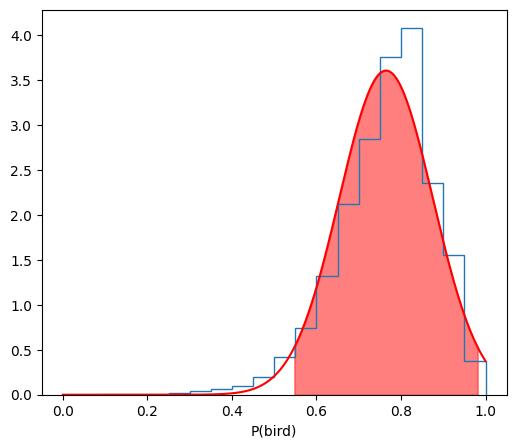

In [90]:
#Output distribution for most probable class (normalized)
from scipy.stats import norm
fig, axs = plt.subplots(1,1, figsize=(6,5))

axs.hist(preds_bnn[:,np.argmax(y_val[idx])], bins=20, range=(0,1), density=True, histtype='step')
axs.set_xlabel(f"P({labels_no_horse[np.argmax(y_val[idx])]})")

#Example: Confidence intervals via Gaussian approximation

mean = np.mean(preds_bnn[:,np.argmax(y_val[idx])])
std = np.std(preds_bnn[:,np.argmax(y_val[idx])])

x_axis = np.arange(0, 1, 0.0001)
pdf = norm.pdf(x_axis,mean,std)
axs.plot(x_axis, pdf, 'r')

std_lim = 1.96 # 95% CI
low = mean-std_lim*std
high = mean+std_lim*std

print(f"95% Confidence Interval ({labels_no_horse[np.argmax(y_val[idx])]}): ", np.round(low,2), "-", np.round(high,2))

axs.fill_between(x_axis, pdf, where=(low < x_axis) & (x_axis < high), alpha=0.5, color='red')
None
###############################################################################
# classid = 6
# axs[1].hist(preds_bnn[:,classid], bins=20, range=(0,1), density=True, histtype='step')
# axs[1].set_xlabel(f"P({labels_no_horse[classid]})")

# #Example: Confidence intervals via Gaussian approximation
# mean = np.mean(preds_bnn[:,classid])
# std = np.std(preds_bnn[:,classid])

# x_axis = np.arange(0, 1, 0.0001)
# pdf = norm.pdf(x_axis,mean,std)
# axs[1].plot(x_axis, pdf, 'r')

# std_lim = 1.96 # 95% CI
# low = mean-std_lim*std
# high = mean+std_lim*std

# print(f"95% Confidence Interval ({labels_no_horse[classid]}): ", np.round(low,2), "-", np.round(high,2))

# axs[1].fill_between(x_axis, pdf, where=(low < x_axis) & (x_axis < high), alpha=0.5, color='red')

In [16]:
#Calculate both validation accuracies
print("Performance on x_val:")
model_acc = np.round(model.evaluate(x=x_val, y=y_val)[1],2)
model_bnn_acc = np.round(model_bnn.evaluate(x=x_val, y=y_val)[1],2)

Performance on x_val:
18000/18000 [==============================] - 30s 2ms/sample - loss: 1.4504 - accuracy: 0.6448


In [17]:
#Predict x_test
pred = np.array(model.predict(x_test))

pred_bnn = np.array([model_bnn.predict(x_test) for _ in range(2)])
pred_mean = np.mean(pred_bnn, axis=0)
pred_std = np.std(pred_bnn, axis=0)

pred_labels = np.argmax(pred, axis=1)
pred_labels_bnn = np.argmax(pred_mean, axis=1)

9000
1000


Text(0.5, 0.98, 'Unknown images (class: horse) classified as:')

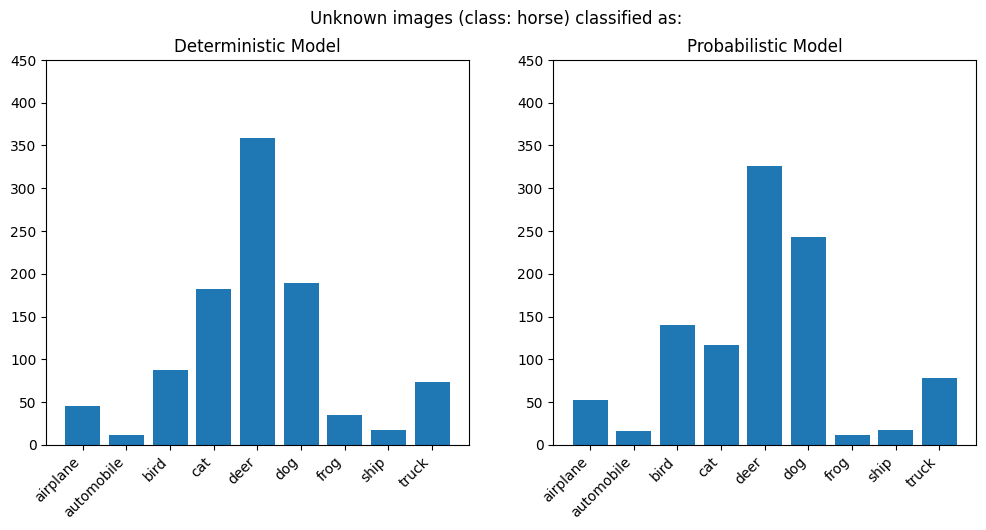

In [21]:
#Predict all images in x_test, where class=horse
known_idx=np.where(y_test!=7)[0]
unknown_idx=np.where(y_test==7)[0]

print(len(known_idx))
print(len(unknown_idx))

fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].bar(np.unique(pred_labels[unknown_idx],return_counts=True)[0],np.unique(pred_labels[unknown_idx],return_counts=True)[1])

axs[0].set_xticks(x)
axs[1].set_xticks(x)
axs[0].set_xticklabels(labels_no_horse, rotation=45, ha='right')
axs[1].set_xticklabels(labels_no_horse, rotation=45, ha='right')

axs[0].set_title("Deterministic Model")
axs[0].set_ylim([0,450])

axs[1].bar(np.unique(pred_labels_bnn[unknown_idx],return_counts=True)[0],np.unique(pred_labels_bnn[unknown_idx],return_counts=True)[1])
axs[1].set_title("Probabilistic Model")
axs[1].set_ylim([0,450])
fig.suptitle('Unknown images (class: horse) classified as:')

[Text(0, 0, 'airplane'),
 Text(0, 0, 'automobile'),
 Text(0, 0, 'bird'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'deer'),
 Text(0, 0, 'dog'),
 Text(0, 0, 'frog'),
 Text(0, 0, 'ship'),
 Text(0, 0, 'truck')]

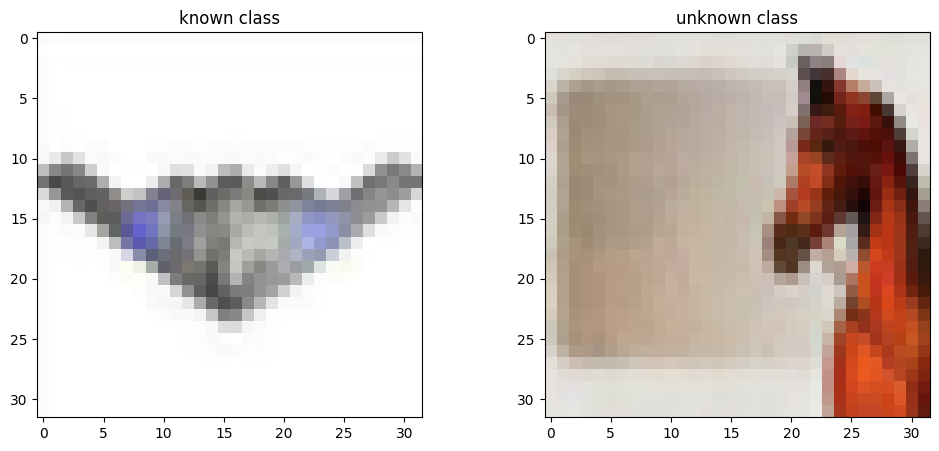

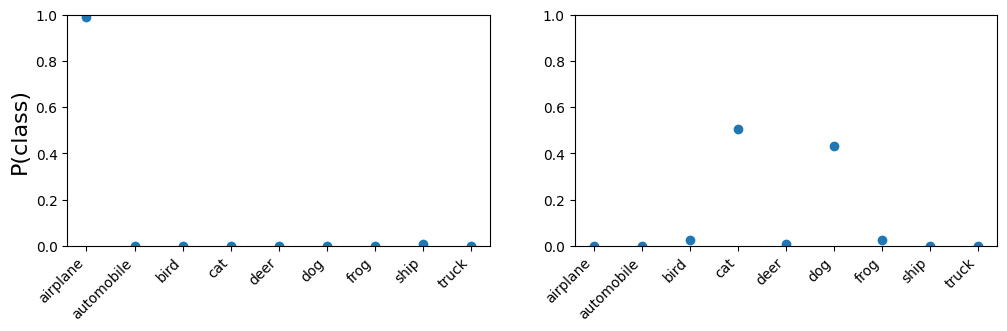

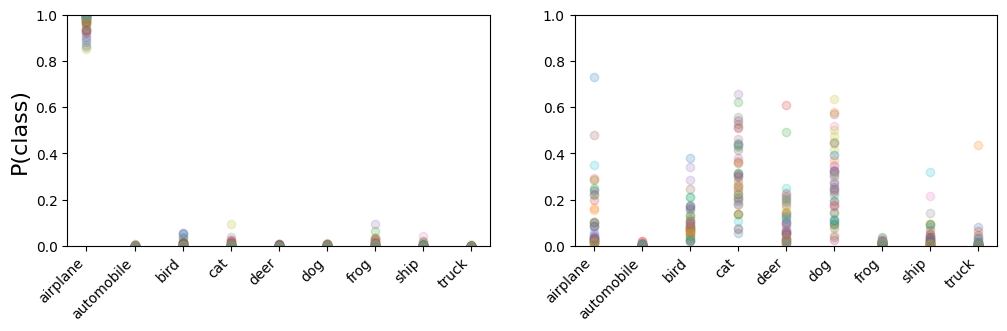

In [19]:
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

np.random.seed(7681)
random_sample_known=np.random.choice(range(0,len(x_test_known)),1)
np.random.seed(2384)
random_sample_unknown=np.random.choice(range(0,len(x_test_unknown)),1)

fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].imshow(np.squeeze(np.array(((((x_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
axs[0].set_title("known class")
axs[1].imshow(np.squeeze(np.array(((((x_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
axs[1].set_title("unknown class")

fig, axs = plt.subplots(1,2,figsize=(12,3))
axs[0].scatter(range(0,9),model.predict(x_test_known[random_sample_known]))
axs[0].set_ylabel("P(class)",fontsize=16)
axs[0].set_ylim([0,1])
axs[1].scatter(range(0,9),model.predict(x_test_unknown[random_sample_unknown]))
axs[1].set_ylim([0,1])
axs[0].set_xticks(x)
axs[1].set_xticks(x)
axs[0].set_xticklabels(labels_no_horse, rotation=45, ha='right')
axs[1].set_xticklabels(labels_no_horse, rotation=45, ha='right')

fig, axs = plt.subplots(1,2,figsize=(12,3))
for i in range(0,50):
  axs[0].scatter(range(0,9),model_bnn.predict(x_test_known[random_sample_known]),alpha=0.2)
axs[0].set_ylabel("P(class)",fontsize=16)
axs[0].set_ylim([0,1])
for i in range(0,50):
  axs[1].scatter(range(0,9),model_bnn.predict(x_test_unknown[random_sample_unknown]),alpha=0.2)
axs[1].set_ylim([0,1])
axs[0].set_xticks(x)
axs[1].set_xticks(x)
axs[0].set_xticklabels(labels_no_horse, rotation=45, ha='right')
axs[1].set_xticklabels(labels_no_horse, rotation=45, ha='right')
